In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ravens import tasks
from ravens.environments import environment
from ravens.utils import utils

import pybullet as p
import copy

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [3]:
ASSETS_PATH = '../ravens/environments/assets/'

In [4]:
# Helper methods
def plot(obs):
    plt.figure()
    plt.imshow(obs)
    plt.axis('off')
    plt.show()
    plt.close()

In [5]:
class ContinuousEnvironment(environment.Environment):
    def reset(self):
        self.s_bit = 0
        return super().reset()
    
    def get_ee_pose(self):
        return p.getLinkState(self.ur5, self.ee_tip)[0:2]
        
    def step(self, action=None):
        if action is not None:
            action, suction = action
            timeout = self.movep(action)
            if timeout:
                obs = self._get_obs()
                return obs, 0.0, True, self.info
            if suction:
                if self.s_bit:
                    self.ee.release()
                else:
                    self.ee.activate()
                self.s_bit = not self.s_bit

        # Step simulator asynchronously until objects settle.
        while not self.is_static:
            p.stepSimulation()

        # Get task rewards.
        reward, info = self.task.reward() if action is not None else (0, {})
        done = self.task.done()

        # Add ground truth robot state into info.
        info.update(self.info)

        obs = self._get_obs()

        return obs, reward, done, info

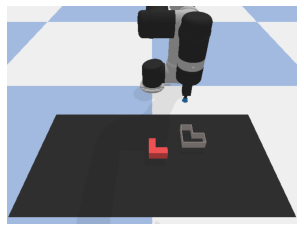

In [6]:
# env = environment.Environment(ASSETS_PATH)
env = ContinuousEnvironment(ASSETS_PATH)
task = tasks.BlockInsertionEasy()
env.set_task(task)
env.seed()
agent = task.oracle(env)
obs = env.reset()
plot(obs['color'][0])
info = None
act = agent.act(obs, info)  # Expert action.

In [7]:
NUM_POSES = 7
TIME_MAX = 10
# STEPS_TOTAL = 30  # ideally a multiple of num_poses
STEPS_PER_SEG = 5
STEPS_TOTAL = int(STEPS_PER_SEG * NUM_POSES)
# STEPS_PER_SEG = np.floor(STEPS_TOTAL / NUM_POSES).astype(int)
print(STEPS_TOTAL)

time = np.linspace(0, TIME_MAX, NUM_POSES, endpoint=True)
print(time)

xnew = []
for i in range(len(time)):
    if i >= len(time) - 1:
        break
    linsp = np.linspace(time[i], time[i+1], STEPS_PER_SEG, endpoint=False)
    xnew.extend(linsp)
xnew.append(time[-1])

xnew = np.array(xnew)
print(len(xnew))

35
[0.0000 1.6667 3.3333 5.0000 6.6667 8.3333 10.0000]
31


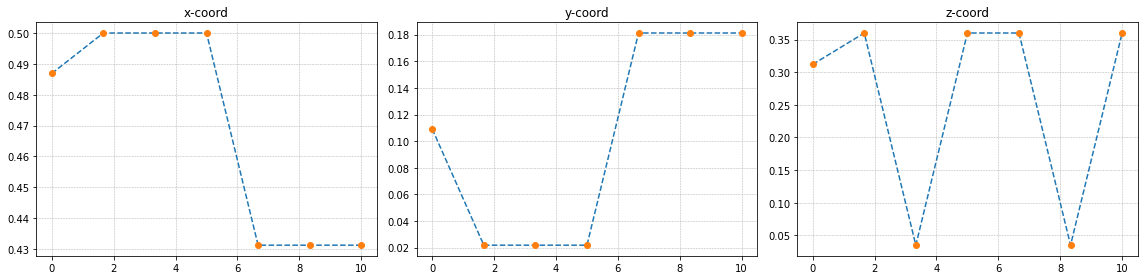

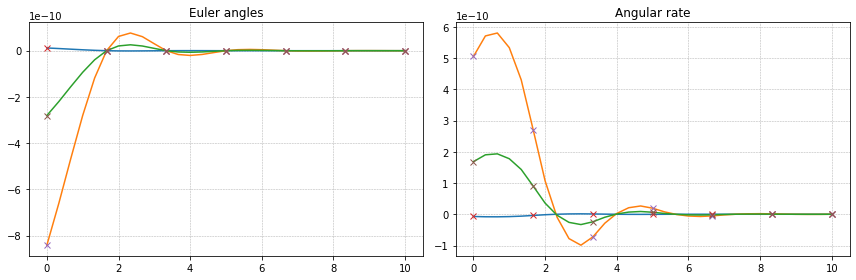

In [8]:
planner = tasks.planners.PathPlanner(env.get_ee_pose(), act['pose0'], act['pose1'])
plan = planner.plan(xnew)
planner.plot_xyz(xnew)
planner.plot_quat(xnew)

In [9]:
suction_idxs = [2, 5]
suction_times = [planner.times[i] for i in suction_idxs]
suction_loc = [np.argwhere(xnew == s)[0][0] for s in suction_times]

In [10]:
actions = []
for i, pose in enumerate(plan):
    s = 0
    if i in suction_loc:
        s = 1
    actions.append((pose, s))

In [11]:
obses = []
for i, act_ in enumerate(actions):
    if not i % 10:
        print(i)
    obs, _, done, info = env.step(act_)
    obses.append(obs['color'][0])
    if done:
        print("Done, exiting.")
        break

0
10
20
Popping...
Popping...
Popping...
Popping...
Popping...
Popping...
Popping...
Popping...
Popping...
Popping...
30
Popping...


In [12]:
import imageio
from IPython.display import Video

imageio.mimsave("demo.mp4", obses, fps=10)
Video("demo.mp4")